In [8]:
import warnings
warnings.filterwarnings("ignore")  # "error", "ignore", "always", "default", "module" or "once"

In [9]:
import numpy as np
import pandas as pd
import random
import os
#from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

from federated_utils_fedavg import *

In [10]:
#declear path to your data
drebin_data_path = '/home/gp/Desktop/ayushi-malware/SoCTA-2022/data/drebin.csv'
malgenome_data_path = '/home/gp/Desktop/ayushi-malware/SoCTA-2022/data/malgenome.csv'
kronodroid_data_path = '/home/gp/Desktop/ayushi-malware/SoCTA-2022/data/kronodroid.csv'
TUANDROMD_data_path='/home/gp/Desktop/ayushi-malware/SoCTA-2022/data/TUANDROMD.csv'



Drebin_data = pd.read_csv(drebin_data_path, header = None)

Malgenome_data = pd.read_csv(malgenome_data_path)

Tuandromd_data=pd.read_csv(TUANDROMD_data_path)

kronodroid_data=pd.read_csv(kronodroid_data_path)
Kronodroid_data = kronodroid_data.iloc[:,range(1,kronodroid_data.shape[1])]

In [11]:

n_clients = [5,10,15]
n_round = [10,20]

dataset = ['Drebin', 'Malgenome', 'Kronodroid', 'Tuandromd' ]


for d in range(0,len(dataset)):
    if d == 0:
        use_data = Drebin_data
    elif d==1:
        use_data = Malgenome_data
    elif d==2:
        use_data = Kronodroid_data
    elif d==3:
        use_data = Tuandromd_data
        
        
    print('===================================================================================================')
    print('Working with:',dataset[d])
    print('===================================================================================================')

    for r in n_round: #number of rounds loop
        comms_round = r
        for cl in n_clients: #number of clients loop
            number_of_clients = cl

            # from sklearn.utils import shuffle
            # use_data = shuffle(use_data)
            # use_data
            print('---------------------------------------------')
            print('No. of Clients:', number_of_clients)
            print('No. of Rounds:', comms_round)
            print('---------------------------------------------')


            features = np.array(use_data.iloc[:,range(0,use_data.shape[1]-1)]) #feature set

            labels = use_data.iloc[:,-1] #labels --> B : Benign and S


            #Do feature scaling 


            X = preprocessing.StandardScaler().fit(features).transform(features)


            #binarize the labels
            lb = LabelBinarizer()
            y = lb.fit_transform(labels)


            #split data into training and test set
            X_train, X_test, y_train, y_test = train_test_split(X, 
                                                                y, shuffle=True,
                                                                test_size=0.2, 
                                                                random_state=100)



            #create clients -- Horizontal FL
            clients = create_clients(X_train, y_train, num_clients=number_of_clients, initial='client')

            #process and batch the training data for each client
            clients_batched = dict()
            for (client_name, data) in clients.items():
                clients_batched[client_name] = batch_data(data)


                #process and batch the test set  
            test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

            #==============================================
            # Traditional FedAvg 2017
            #==============================================
            #-----------------------------------------------


            all_results=list()

            #create optimizer
            lr = 0.01 
            loss='binary_crossentropy'
            metrics = ['accuracy']
            optimizer = SGD(learning_rate=lr, 
                            decay=lr / comms_round, 
                            momentum=0.9
                           )

            #initialize global model
            smlp_global = SimpleMLP()
            global_model = smlp_global.build(X.shape[1],1)
            #-----------------------------------------------


            print('|=======================|')
            print('|Traditional FedAvg 2017|')
            print('|=======================|')

            #commence global training loop
            for comm_round in range(comms_round):

                # get the global model's weights - will serve as the initial weights for all local models
                global_weights = global_model.get_weights()

                #initial list to collect local model weights after scalling
                scaled_local_weight_list = list()

                #randomize client data - using keys
                client_names= list(clients_batched.keys())
                random.shuffle(client_names)

                #loop through each client and create new local model
                for client in client_names:
                    smlp_local = SimpleMLP()
                    local_model = smlp_local.build(X.shape[1],1)
                    local_model.compile(loss=loss, 
                                  optimizer=optimizer, 
                                  metrics=metrics)

                    #set local model weight to the weight of the global model
                    local_model.set_weights(global_weights)

                    #fit local model with client's data
                    local_model.fit(clients_batched[client], epochs=32, verbose=0)

                    #scale the model weights and add to list
                    scaling_factor = weight_scalling_factor(clients_batched, client)
                    scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
                    scaled_local_weight_list.append(scaled_weights)

                    #clear session to free memory after each communication round
                    K.clear_session()

                #to get the average over all the local model, we simply take the sum of the scaled weights
                average_weights = sum_scaled_weights(scaled_local_weight_list)

                #update global model 
                global_model.set_weights(average_weights)

                #test global model and print out metrics after each communications round
                for(X_test, Y_test) in test_batched:
                    global_acc, global_loss, global_f1, global_precision, global_recall, global_auc = test_model(X_test, Y_test, global_model, comm_round)
                    all_results.append([global_acc,global_loss.numpy(),global_f1, global_precision, global_recall, global_auc])



            all_R = pd.DataFrame(all_results, columns=['global_acc', 'global_loss', 'global_f1', 'global_precision', 'global_recall', 'global_auc'])
            flname = 'results/round-'+str(r)+'/'+str(cl)+'-clients/FedAvg-'+dataset[d]+'-results.csv'
            all_R.to_csv(flname, index=None)

Working with: Drebin
---------------------------------------------
No. of Clients: 5
No. of Rounds: 10
---------------------------------------------
|=======================|
|Traditional FedAvg 2017|
|=======================|
comm_round: 0 | global_acc: 98.072% | global_loss: 0.5644536018371582 | global_f1: 0.9737080689029918 | global_precision: 0.9790337283500455 | global_recall: 0.9684400360685302 | global_auc: 0.9961728231507162 
comm_round: 1 | global_acc: 98.338% | global_loss: 0.5637807846069336 | global_f1: 0.977416440831075 | global_precision: 0.9791855203619909 | global_recall: 0.975653742110009 | global_auc: 0.9965564905073193 
comm_round: 2 | global_acc: 98.404% | global_loss: 0.5632815957069397 | global_f1: 0.9783001808318263 | global_precision: 0.9809610154125114 | global_recall: 0.975653742110009 | global_auc: 0.9966125211361303 
comm_round: 3 | global_acc: 98.471% | global_loss: 0.5630653500556946 | global_f1: 0.9792231255645889 | global_precision: 0.9809954751131221 | 

comm_round: 4 | global_acc: 98.570% | global_loss: 0.5615749955177307 | global_f1: 0.9804811620517476 | global_precision: 0.9872029250457038 | global_recall: 0.9738503155996393 | global_auc: 0.9964779051762329 
comm_round: 5 | global_acc: 98.570% | global_loss: 0.5614472031593323 | global_f1: 0.9804811620517476 | global_precision: 0.9872029250457038 | global_recall: 0.9738503155996393 | global_auc: 0.9964871644750619 
comm_round: 6 | global_acc: 98.604% | global_loss: 0.5613780617713928 | global_f1: 0.9809437386569873 | global_precision: 0.9872146118721461 | global_recall: 0.9747520288548241 | global_auc: 0.9965002224605899 
comm_round: 7 | global_acc: 98.570% | global_loss: 0.5613581538200378 | global_f1: 0.9804988662131519 | global_precision: 0.9863138686131386 | global_recall: 0.9747520288548241 | global_auc: 0.9965275255212391 
comm_round: 8 | global_acc: 98.570% | global_loss: 0.5612326860427856 | global_f1: 0.9804988662131519 | global_precision: 0.9863138686131386 | global_recall

comm_round: 1 | global_acc: 97.606% | global_loss: 0.5678122639656067 | global_f1: 0.967391304347826 | global_precision: 0.9717925386715196 | global_recall: 0.9630297565374211 | global_auc: 0.9949306526001298 
comm_round: 2 | global_acc: 97.939% | global_loss: 0.5666167736053467 | global_f1: 0.9719710669077758 | global_precision: 0.9746146872166818 | global_recall: 0.9693417493237151 | global_auc: 0.9952397707302643 
comm_round: 3 | global_acc: 98.072% | global_loss: 0.5660750269889832 | global_f1: 0.973803071364047 | global_precision: 0.9755656108597285 | global_recall: 0.9720468890892696 | global_auc: 0.9953869698398521 
comm_round: 4 | global_acc: 98.138% | global_loss: 0.5657880306243896 | global_f1: 0.9747520288548241 | global_precision: 0.9747520288548241 | global_recall: 0.9747520288548241 | global_auc: 0.9954316044085659 
comm_round: 5 | global_acc: 98.105% | global_loss: 0.5655581951141357 | global_f1: 0.9742895805142084 | global_precision: 0.9747292418772563 | global_recall: 

comm_round: 7 | global_acc: 99.474% | global_loss: 0.5686751008033752 | global_f1: 0.9923076923076923 | global_precision: 0.9885057471264368 | global_recall: 0.9961389961389961 | global_auc: 0.9998612812984071 
comm_round: 8 | global_acc: 99.474% | global_loss: 0.5685442686080933 | global_f1: 0.9923076923076923 | global_precision: 0.9885057471264368 | global_recall: 0.9961389961389961 | global_auc: 0.9998689878929401 
comm_round: 9 | global_acc: 99.474% | global_loss: 0.5684441328048706 | global_f1: 0.9923076923076923 | global_precision: 0.9885057471264368 | global_recall: 0.9961389961389961 | global_auc: 0.999876694487473 
---------------------------------------------
No. of Clients: 15
No. of Rounds: 10
---------------------------------------------
|=======================|
|Traditional FedAvg 2017|
|=======================|
comm_round: 0 | global_acc: 97.500% | global_loss: 0.579512357711792 | global_f1: 0.9625246548323472 | global_precision: 0.9838709677419355 | global_recall: 0.94

comm_round: 3 | global_acc: 99.211% | global_loss: 0.5690769553184509 | global_f1: 0.9884615384615385 | global_precision: 0.9846743295019157 | global_recall: 0.9922779922779923 | global_auc: 0.9997688021640118 
comm_round: 4 | global_acc: 99.211% | global_loss: 0.5688044428825378 | global_f1: 0.9884615384615385 | global_precision: 0.9846743295019157 | global_recall: 0.9922779922779923 | global_auc: 0.9997765087585447 
comm_round: 5 | global_acc: 99.342% | global_loss: 0.5686073899269104 | global_f1: 0.9904030710172744 | global_precision: 0.9847328244274809 | global_recall: 0.9961389961389961 | global_auc: 0.9997842153530777 
comm_round: 6 | global_acc: 99.342% | global_loss: 0.5684801340103149 | global_f1: 0.9904030710172744 | global_precision: 0.9847328244274809 | global_recall: 0.9961389961389961 | global_auc: 0.9997842153530777 
comm_round: 7 | global_acc: 99.342% | global_loss: 0.5683848261833191 | global_f1: 0.9904030710172744 | global_precision: 0.9847328244274809 | global_recall

|=======================|
|Traditional FedAvg 2017|
|=======================|
comm_round: 0 | global_acc: 95.284% | global_loss: 0.5206847190856934 | global_f1: 0.9551348389845985 | global_precision: 0.9629311402970419 | global_recall: 0.947463768115942 | global_auc: 0.9861307934197481 
comm_round: 1 | global_acc: 96.161% | global_loss: 0.520166277885437 | global_f1: 0.9636187242299297 | global_precision: 0.9676083779834389 | global_recall: 0.9596618357487923 | global_auc: 0.9885953307482532 
comm_round: 2 | global_acc: 96.238% | global_loss: 0.5188765525817871 | global_f1: 0.9643765903307888 | global_precision: 0.9675419401896426 | global_recall: 0.961231884057971 | global_auc: 0.9895593858396514 
comm_round: 3 | global_acc: 96.308% | global_loss: 0.5182652473449707 | global_f1: 0.9650958804670013 | global_precision: 0.966791904011635 | global_recall: 0.9634057971014492 | global_auc: 0.9900868634930402 
comm_round: 4 | global_acc: 96.397% | global_loss: 0.5176607370376587 | global_f1:

comm_round: 6 | global_acc: 96.826% | global_loss: 0.5126535296440125 | global_f1: 0.9700120918984281 | global_precision: 0.9711864406779661 | global_recall: 0.9688405797101449 | global_auc: 0.9913120070793854 
comm_round: 7 | global_acc: 96.852% | global_loss: 0.5123897194862366 | global_f1: 0.9702539298669892 | global_precision: 0.9714285714285714 | global_recall: 0.9690821256038648 | global_auc: 0.9913527769888418 
comm_round: 8 | global_acc: 96.852% | global_loss: 0.512301504611969 | global_f1: 0.9702539298669892 | global_precision: 0.9714285714285714 | global_recall: 0.9690821256038648 | global_auc: 0.9914165575305253 
comm_round: 9 | global_acc: 96.871% | global_loss: 0.512149453163147 | global_f1: 0.9704478153139542 | global_precision: 0.9712108382726503 | global_recall: 0.9696859903381643 | global_auc: 0.9914149139139375 
comm_round: 10 | global_acc: 96.884% | global_loss: 0.5118926763534546 | global_f1: 0.9705544470645141 | global_precision: 0.9717883521007386 | global_recall:

comm_round: 3 | global_acc: 95.815% | global_loss: 0.5216009616851807 | global_f1: 0.9602721419025634 | global_precision: 0.9660229772671718 | global_recall: 0.9545893719806763 | global_auc: 0.9878552923796675 
comm_round: 4 | global_acc: 95.962% | global_loss: 0.5209743976593018 | global_f1: 0.9617041937245857 | global_precision: 0.9665731365133585 | global_recall: 0.9568840579710145 | global_auc: 0.9882684975898006 
comm_round: 5 | global_acc: 96.058% | global_loss: 0.5205644965171814 | global_f1: 0.962653085970656 | global_precision: 0.9665205746286827 | global_recall: 0.9588164251207729 | global_auc: 0.9884901228504783 
comm_round: 6 | global_acc: 96.142% | global_loss: 0.5201890468597412 | global_f1: 0.9634434677174902 | global_precision: 0.9672550213024954 | global_recall: 0.9596618357487923 | global_auc: 0.988660795996939 
comm_round: 7 | global_acc: 96.174% | global_loss: 0.5198901891708374 | global_f1: 0.9637663596703829 | global_precision: 0.9670476653696498 | global_recall: 

comm_round: 9 | global_acc: 98.880% | global_loss: 0.391444593667984 | global_f1: 0.9931412894375857 | global_precision: 0.9917808219178083 | global_recall: 0.9945054945054945 | global_auc: 0.9990717615717616 
---------------------------------------------
No. of Clients: 15
No. of Rounds: 10
---------------------------------------------
|=======================|
|Traditional FedAvg 2017|
|=======================|
comm_round: 0 | global_acc: 96.865% | global_loss: 0.40221306681632996 | global_f1: 0.9806896551724138 | global_precision: 0.9847645429362881 | global_recall: 0.9766483516483516 | global_auc: 0.9956793206793206 
comm_round: 1 | global_acc: 97.872% | global_loss: 0.3975645899772644 | global_f1: 0.9868512110726644 | global_precision: 0.9944211994421199 | global_recall: 0.9793956043956044 | global_auc: 0.9972735597735598 
comm_round: 2 | global_acc: 97.872% | global_loss: 0.39585548639297485 | global_f1: 0.9868512110726644 | global_precision: 0.9944211994421199 | global_recall: 0

comm_round: 5 | global_acc: 98.656% | global_loss: 0.39207684993743896 | global_f1: 0.9917582417582418 | global_precision: 0.9917582417582418 | global_recall: 0.9917582417582418 | global_auc: 0.9984015984015985 
comm_round: 6 | global_acc: 98.656% | global_loss: 0.39189833402633667 | global_f1: 0.9917582417582418 | global_precision: 0.9917582417582418 | global_recall: 0.9917582417582418 | global_auc: 0.9982892107892108 
comm_round: 7 | global_acc: 98.656% | global_loss: 0.391783207654953 | global_f1: 0.9917582417582418 | global_precision: 0.9917582417582418 | global_recall: 0.9917582417582418 | global_auc: 0.9982975357975358 
comm_round: 8 | global_acc: 98.880% | global_loss: 0.3916687071323395 | global_f1: 0.9931224209078404 | global_precision: 0.9944903581267218 | global_recall: 0.9917582417582418 | global_auc: 0.9982392607392607 
comm_round: 9 | global_acc: 98.880% | global_loss: 0.3915771543979645 | global_f1: 0.9931224209078404 | global_precision: 0.9944903581267218 | global_recal

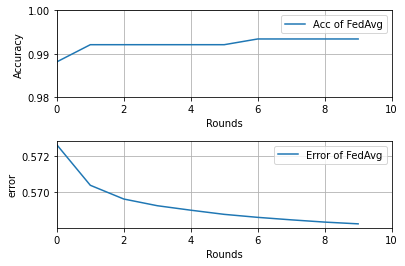

In [27]:
import numpy as np
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1)
# make a little extra space between the subplots
fig.subplots_adjust(hspace=0.5)

s1 = np.array(all_results) #FedAvg

t = range(0,s1.shape[0])

ax1.plot(t, s1[:,0],label='Acc of FedAvg')
ax1.set_xlim(0,s1.shape[0])
ax1.set_xlabel('Rounds')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0.98,1)
ax1.grid(True)
ax1.legend()


ax2.plot(t, s1[:,1],label='Error of FedAvg')
ax2.set_xlim(0, s1.shape[0])
ax2.set_xlabel('Rounds')
ax2.set_ylabel('error')
ax2.grid(True)
ax2.legend()

plt.show()



In [26]:
s1.shape

(10, 2)